Client Retention Demo Using Python

In [71]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Load transaction data
txn_df = pd.read_csv('transactions.csv')
txn_df['TX_TOTAL_AMT'] = pd.to_numeric(txn_df['TX_TOTAL_AMT'])
txn_df['CONT_ID'] = txn_df['CONT_ID'].astype('int64')
txn_df['DATE_CREDIT'] = pd.to_datetime(txn_df['DATE_CREDIT'])
txn_df['date'] = txn_df['DATE_CREDIT'].apply(lambda x: x.date())

# Load client data
client_df = pd.read_csv('clients.csv')
client_df = client_df.set_index("CONT_ID")


In [72]:
# Total transactions per customer
total_txns_df = txn_df.groupby('CONT_ID').size().rename("total_txns").to_frame()
client_df = total_txns_df.join(client_df)

# Total transaction amounts per customer
total_txn_amount_df = txn_df.groupby('CONT_ID')['TX_TOTAL_AMT'].sum().rename("total_txn_amount").to_frame()
client_df = client_df.join(total_txn_amount_df)

# Average transaction amounts per customer
avg_txn_amount_df = txn_df.groupby('CONT_ID')['TX_TOTAL_AMT'].mean().rename("avg_txn_amount").to_frame()
client_df = client_df.join(avg_txn_amount_df)

# Average daily transactions per customer
daily_txns = txn_df.groupby(['date', 'CONT_ID']).size()
avg_daily_txns_df = daily_txns.unstack().fillna(0).mean().rename("avg_daily_txns").to_frame()
client_df = client_df.join(avg_daily_txns_df)


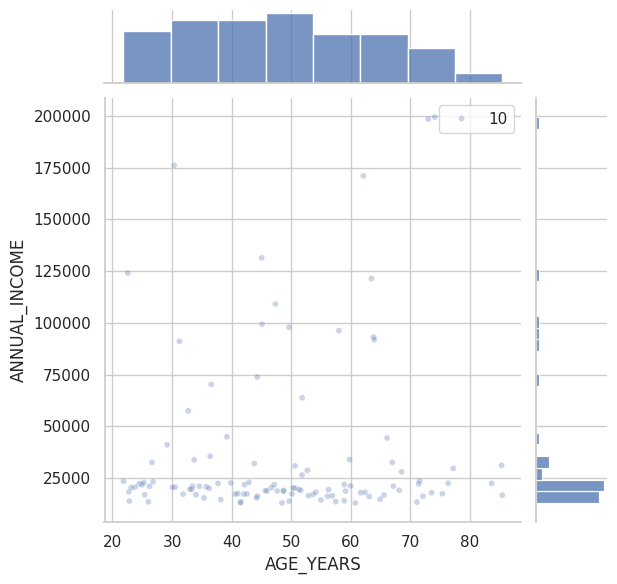

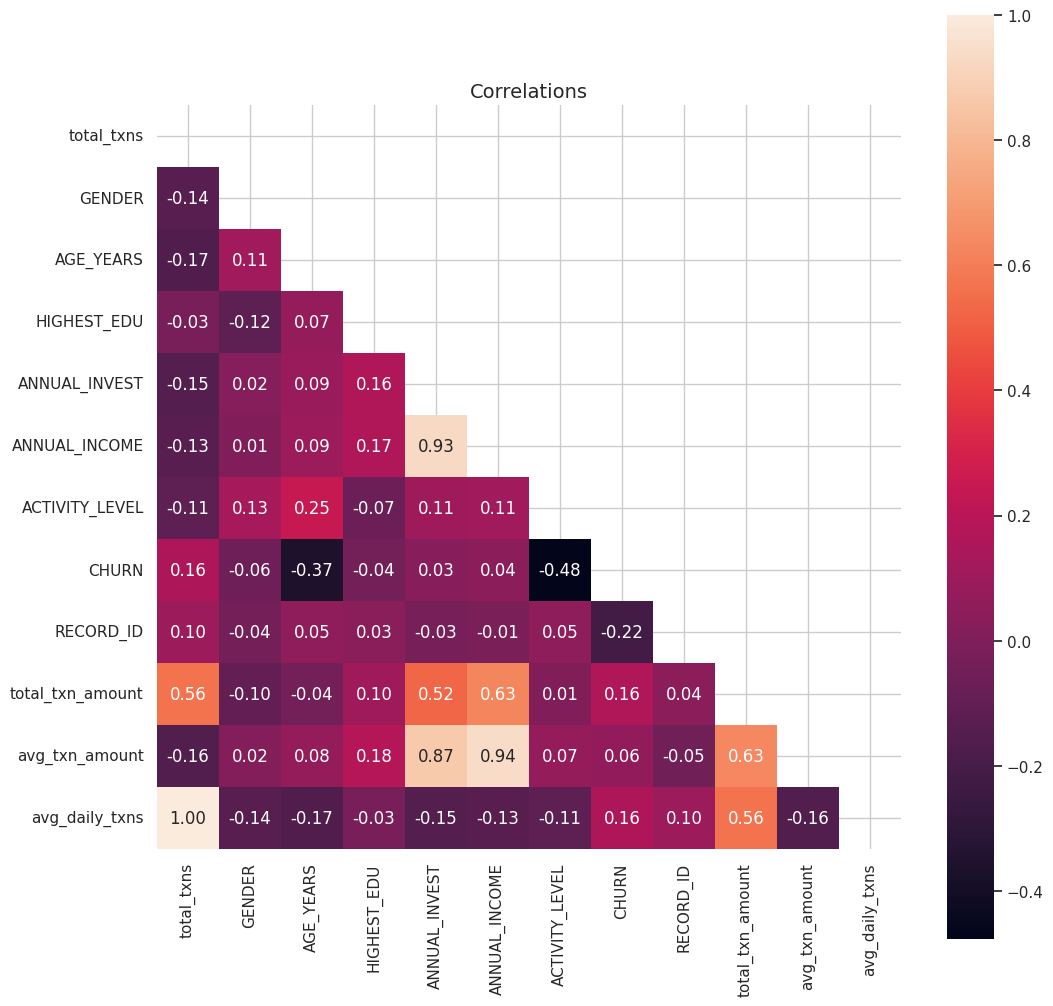

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
%matplotlib inline

# Scatterplot for AGE_YEARS vs. ANNUAL_INCOME
def plot_joint(x, y, data):
    return sns.jointplot(x=x, y=y, data=data, alpha=0.3, size=10)

plot_joint('AGE_YEARS', 'ANNUAL_INCOME', client_df)

# Correlation matrix
corr = client_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(12, 12))
sns.heatmap(corr, mask=mask, square=True, annot=True, fmt='.2f', cbar=True)
plt.title('Correlations', size=14)
plt.show()


In [73]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare the feature space
def make_feature_space(df):
    features_df = df.drop(['CHURN', 'CUSTOMER_ID'], axis=1, errors='ignore')
    X = features_df.to_numpy()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X

# Train the model
train_df, test_df = train_test_split(client_df, test_size=0.2)
y = np.array(train_df['CHURN'])
X = make_feature_space(train_df)

clf = RF(n_estimators=100)
clf.fit(X, y)


RandomForestClassifier()

In [74]:
from sklearn2pmml import PMMLPipeline, sklearn2pmml

pipeline = PMMLPipeline([("classifier", clf)])
sklearn2pmml(pipeline, "customer_churn_decision_tree_model.pmml")


In [40]:
def calc_business_loss_random_forest(df):
    df['CUSTOMER_ID'] = df.index
    data = df.copy()

    # Extract features
    X = make_feature_space(df)
    data['churn_probability'] = clf.predict_proba(X)[:, 1]
    
    avg_daily_balance = df['ANNUAL_INCOME'] / 6
    deposit_rate = 0.02
    credit_rate = 0.015
    mgmt_rate = 0.02

    worth = deposit_rate * avg_daily_balance + \
            mgmt_rate * df['ANNUAL_INVEST'] + \
            credit_rate * df['total_txn_amount']
    data['worth'] = worth
    data['predicted_loss'] = data['churn_probability'] * worth

    return data.sort_values(by='predicted_loss', ascending=False)

churn_df = calc_business_loss_random_forest(test_df)
print(churn_df.head())


            total_txns  GENDER  AGE_YEARS  HIGHEST_EDU  ANNUAL_INVEST  \
CONT_ID                                                                 
1009531270          80       1      63.45            3       100748.0   
1009563510         178       0      36.38            4         9721.0   
1009553230         241       0      26.21            1            0.0   
1009531840         228       0      42.16            1            0.0   
1009557660         243       0      85.32            4            0.0   

            ANNUAL_INCOME  ACTIVITY_LEVEL  CHURN  RECORD_ID  total_txn_amount  \
CONT_ID                                                                         
1009531270       121410.0               3      1     661360           6409.91   
1009563510        35558.0               4      0    2617472          11227.39   
1009553230        21022.0               0      1    1993680           9039.19   
1009531840        21815.0               1      0     695928           9052.69   
10

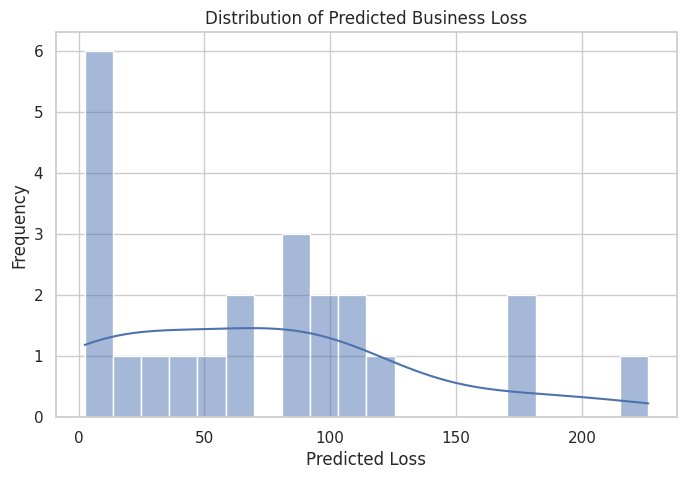

In [75]:
# Predicted Business Loss Distribution
plt.figure(figsize=(8, 5))
sns.histplot(churn_df['predicted_loss'], bins=20, kde=True)
plt.title('Distribution of Predicted Business Loss')
plt.xlabel('Predicted Loss')
plt.ylabel('Frequency')
plt.show()


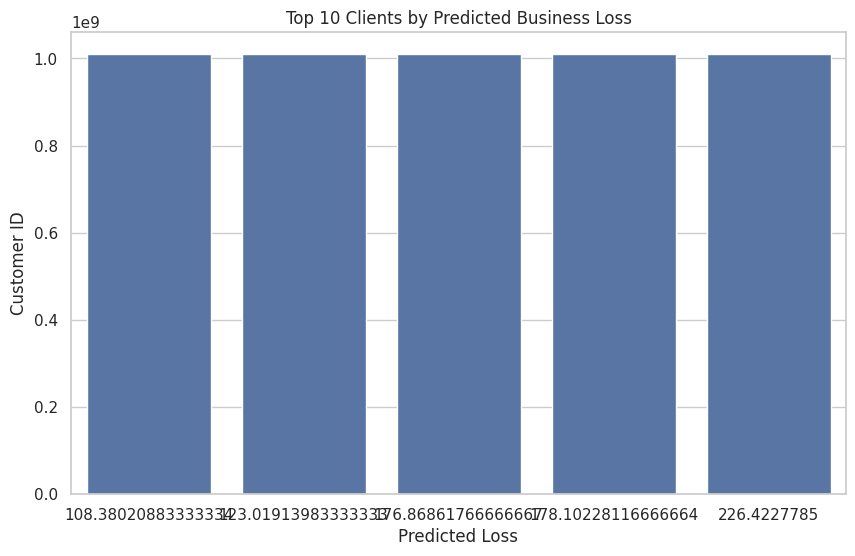

In [76]:
# Top 10 Clients by Predicted Loss
top_clients = churn_df[['CUSTOMER_ID', 'predicted_loss']].sort_values(by='predicted_loss', ascending=False).head(5)

plt.figure(figsize=(10, 6))
sns.barplot(x='predicted_loss', y='CUSTOMER_ID', data=top_clients)
plt.title('Top 10 Clients by Predicted Business Loss')
plt.xlabel('Predicted Loss')
plt.ylabel('Customer ID')
plt.show()


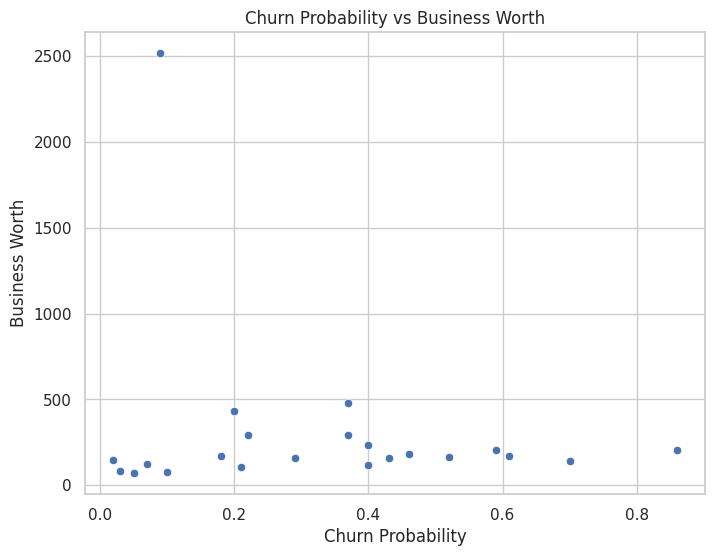

In [57]:
# Scatter Plot: Churn Probability vs Business Worth
plt.figure(figsize=(8, 6))
sns.scatterplot(x='churn_probability', y='worth', data=churn_df)
plt.title('Churn Probability vs Business Worth')
plt.xlabel('Churn Probability')
plt.ylabel('Business Worth')
plt.show()


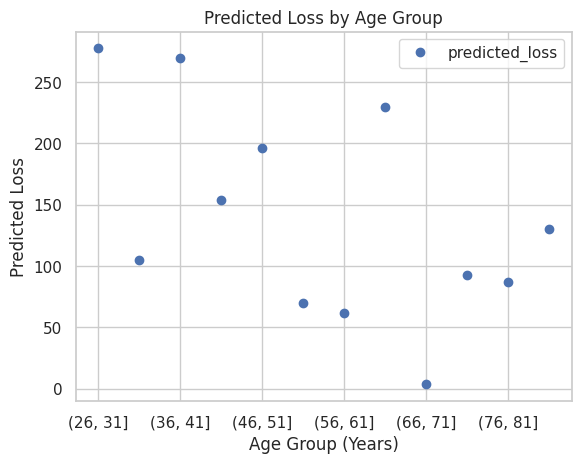

In [50]:
def group_by_age(df, bins=None):
    if bins is None:
        bin_size = 5
        _min, _max = int(df.AGE_YEARS.min()), int(df.AGE_YEARS.max())
        bins = range(_min, _max + bin_size, 5)
    return df.groupby(pd.cut(df.AGE_YEARS, bins=bins))

data_by_age = churn_df.pipe(group_by_age)
loss_by_age_df = data_by_age['predicted_loss'].sum().reset_index()
loss_by_age_df['AGE_YEARS'] = loss_by_age_df['AGE_YEARS'].astype(str)

loss_by_age_df.plot(x='AGE_YEARS', y='predicted_loss', style='o')
plt.title('Predicted Loss by Age Group')
plt.xlabel('Age Group (Years)')
plt.ylabel('Predicted Loss')
plt.show()


In [77]:
import torch
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = torch.from_numpy(scaler.fit_transform(train_df['ACTIVITY_LEVEL'].astype(np.float32).values.reshape(-1, 1)))
x_test = torch.from_numpy(scaler.fit_transform(test_df['ACTIVITY_LEVEL'].astype(np.float32).values.reshape(-1, 1)))
y_train = torch.from_numpy(train_df['CHURN'].astype(np.float32).values).view(-1, 1)

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, no_input_features):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(no_input_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

n_features = 1
lr_model = LogisticRegressionModel(n_features)
